In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import f, norm, chi2
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

In [2]:
seed = 13

# Part A: Linear Regression

## Question 1:

Explanatory variables:
- volatile acidity
- citric acid
- quality


Response variable:
- pH


Research question:
How do changes in volatile acid levels, citric acid levels and quality affect the pH of wine?


## Question 2:

In [3]:
# Load dataset
red_wine_df = pd.read_csv("winequality-red.csv", sep=';')
white_wine_df = pd.read_csv("winequality-white.csv", sep=';')
total_wine_df = pd.concat([red_wine_df, white_wine_df], ignore_index=True)
# Randomly sample 200 instances
samples = total_wine_df.sample(200, ignore_index=True, random_state=seed)

## Question 3:

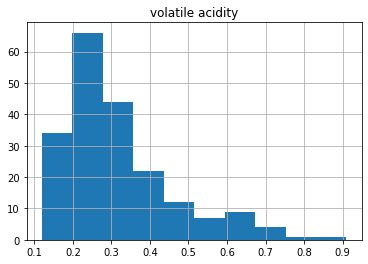

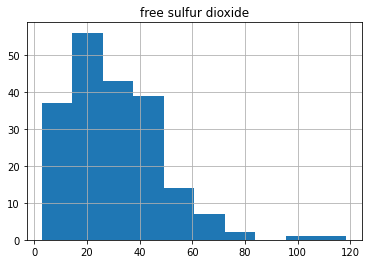

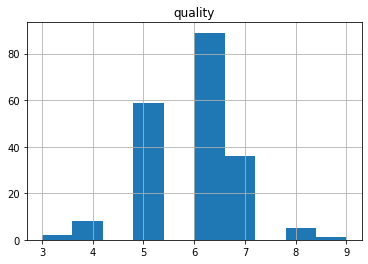

In [4]:
# volatile acids histogram
va_hist = samples.hist('volatile acidity')
ca_hist = samples.hist('free sulfur dioxide')
rs_hist = samples.hist('quality', bins=10)

It seems like the 'volatile acidity' values in the sample data comes from an F-distribution, whereas the 'free sulfur dioxide' values look like a $\chi_3^2$ distribution and the 'quality' values look like a normal distribution.

In general, it is clear that the distribution of the data is not symmetric in any way.
Additionally, the tails of each variable are relatively consistent, therefore it is reasonable to assume that there are no missing values or significant outliers.

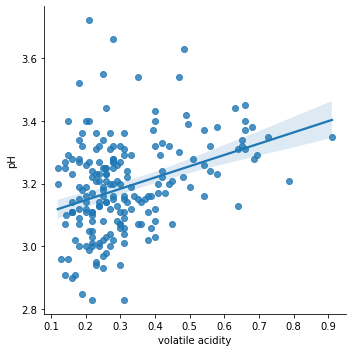

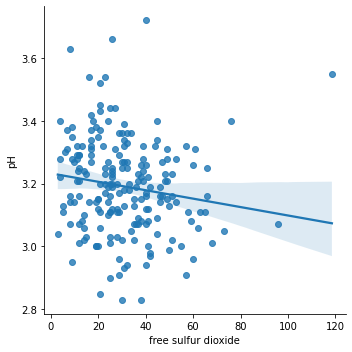

In [5]:
for col in ['volatile acidity', 'free sulfur dioxide']:
    sns.lmplot(x=col, y='pH', data=samples, fit_reg=True, robust=True)

From the slopes of the regression lines fitted on the data of each explanatory variable we can easily see that 'volatile acidity' levels have a more significant effect on 'pH' levels.
This is also apparent from the fact the 'pH' levels are much more widely scattered for every value of 'quality' than for 'volatile acidity'.

<AxesSubplot:title={'center':'pH'}, xlabel='quality'>

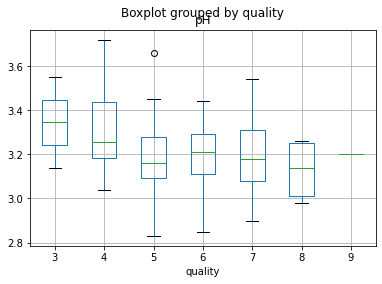

In [6]:
# Boxplot of 'quality' values for every rounded pH value
rounded_pH_df = samples
rounded_pH_df.boxplot(column='pH', by='quality')

## Question 4:

In [7]:
X_np = samples[['volatile acidity', 'quality', 'free sulfur dioxide']].to_numpy()
X = np.concatenate([np.ones((200, 1)), X_np], axis=1)
Y = samples['pH'].to_numpy()
C = np.linalg.inv(X.T @ X)
beta_hat = C @ X.T @ Y
beta_hat

array([ 3.13426044e+00, 3.39641288e-01, -7.27625545e-03, -1.25114290e-04])

Above, we calculated the optimal parameters by the formula seen in the lecture: $\hat{\beta} = \left(X^t X\right)^{-1} X^t y$
In general, these values imply the following:

In [55]:
cols = ['volatile acidity', 'quality', 'free sulfur dioxide']
for param, col in zip(beta_hat, cols):
    if param > 0:
        print(f"An increase of one unit in {col} causes an increase in the log of oddds ratio of {param}")
    else:
        print(f"An increase of one unit in {col} causes an decrease in the log of oddds ratio of {param}")

An increase of one unit in volatile acidity causes an increase in the log of oddds ratio of 3.134260440455383
An increase of one unit in quality causes an increase in the log of oddds ratio of 0.33964128815143746
An increase of one unit in free sulfur dioxide causes an decrease in the log of oddds ratio of -0.007276255454734634


## Question 5:

In [8]:
y_bar = Y.mean()
y_hat = X @ beta_hat
SST = ((Y - y_bar) ** 2).sum()
SSR = ((y_hat - y_bar) ** 2).sum()
SSRes = SST - SSR
R_sq = SSR / SST
# Three explanatory variables and 200 samples
p = 4
n = 200
k = 3
R_sq_adj = 1 - ((n - 1)/(n - p)) * (1 - R_sq)

Now we preform an F-test with the following hypotheses:
$$
 H_0: \beta_1 = \beta_2 = \beta_3 = 0
$$
$$
 H_1: \beta_j \ne 0 \text{ for at least one } j>0 
$$
The test statistic is: 
$$
 \frac{MS_R}{MS_{Res}}
$$

In [9]:
MSR = SSR / k
MSRes = SSRes / (n - p)
TS = MSR / MSRes
reject = (TS > f.ppf(0.95, k, n-p))
p_value = 1 - f.cdf(TS, k, n-p)

In [10]:
def rls(ls):
    return [round(el, 7) for el in ls]

In [11]:
cols = ['Source', 'Sum of Squares', 'df', 'MS', 'F', 'p-value']
rows = ['Regression', 'Residuals', 'Total']
SS = [SSR, SSRes, SST]
df = [p-1, n-p, n-1]
MS = [SSR/df[0], SSRes/df[1], SST/df[2]]
F = [TS, 0, 0]
p_val = [p_value, 0, 0]
datadict = {'Source': rows,
            'Sum of Squares': rls(SS),
            'df': rls(df),
            'MS': rls(MS),
            'F': rls(F),
            'p-value': rls(p_val)}

In [12]:
frame = pd.DataFrame.from_dict(data=datadict)

In [13]:
frame

,Source,Sum of Squares,df,MS,F,p-value
0,Regression,0.552694,3,0.184231,8.897653,0.000015
1,Residuals,4.058304,196,0.020706,0.000000,0.000000
2,Total,4.610998,199,0.023171,0.000000,0.000000


In [14]:
print(f"R^2: {R_sq}")
print(f"Adjusted R^2 : {R_sq_adj}")

R^2: 0.11986440141581346
Adjusted R^2 : 0.10639293817217788


## Question 6: 

We know that $\sigma_\epsilon^2 = MS_{Res}$, therefore $Var(\hat\beta) = MS_{Res}\cdot(X^t X)^{-1}$ and so:
$$
CI(\hat\beta_i) = \left(\hat\beta_i - 2\sqrt{(X^t X)^{-1}_{i,i}\cdot MS_{Res}},\;\; \hat\beta_i + 2\sqrt{(X^t X)^{-1}_{i,i}\cdot MS_{Res}}\right)
$$

In [15]:
# Calculate beta estimator on entire dataset
X_np_all = total_wine_df[['volatile acidity', 'quality', 'free sulfur dioxide']].to_numpy()
X_all = np.concatenate([np.ones((X_np_all.shape[0], 1)), X_np_all], axis=1)
Y_all = total_wine_df['pH'].to_numpy()
beta_hat_all = np.linalg.inv(X_all.T @ X_all) @ X_all.T @ Y_all

In [16]:
# Check if total data estimators are in sample confidence interval
for i in range(len(beta_hat)):
    ci_step = 2 * np.sqrt(C[i,i] * MSRes)
    l = beta_hat[i] - ci_step
    u = beta_hat[i] + ci_step
    print(f"Confidence interval for {i}'th beta entry: {l, u}")
    print(f"Total data estimator in above CI: {(l < beta_hat_all[i] < u)}")

Confidence interval for 0'th beta entry: (2.9647302264119255, 3.3037906544988407)
Total data estimator in above CI: True
Confidence interval for 1'th beta entry: (0.18804115809947236, 0.49124141820340256)
Total data estimator in above CI: True
Confidence interval for 2'th beta entry: (-0.030370423754583202, 0.015817912845113934)
Total data estimator in above CI: False
Confidence interval for 3'th beta entry: (-0.0013675884059457498, 0.001117359825416162)
Total data estimator in above CI: True


## Question 7:

To check whether $\beta^*_0,...,\beta^*_3$ are zero or not, we employ the Wald test on them individually.
Therefore, we test $\forall i=0,1,2,3$:
$$
H_0^i: \hat\beta_i=0 \text{ versus } H_1^i: \hat\beta_i\ne 0
$$
$$
\text{reject }\; H_0 \;\text{ if }\; \frac{\hat\beta_i}{\widehat{se}} > z_{0.025}
$$

In [17]:
for i in range(len(beta_hat)):
    se = np.sqrt(C[i,i] * MSRes)
    rej = (beta_hat[i] / se > norm.ppf(0.975))
    print(f"Beta[i]=0: {rej}")

Beta[i]=0: True
Beta[i]=0: True
Beta[i]=0: False
Beta[i]=0: False


## Question 8:

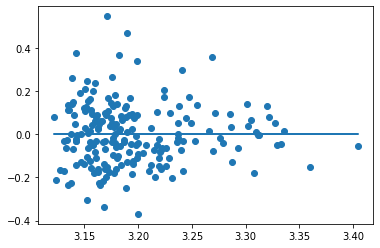

In [18]:
# Residual graph
res = Y - y_hat
zero = np.zeros(len(y_hat))
plt.plot(y_hat, zero)
plt.scatter(y_hat, res)

It seems like both the linearity and constant variance assumptions hold.

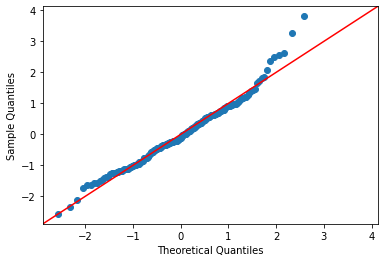

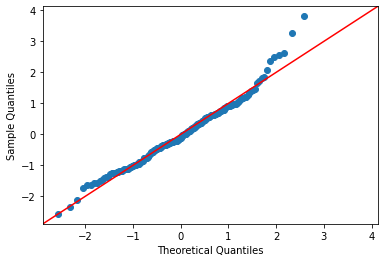

In [19]:
sm.qqplot(res/np.sqrt(MSRes), line ='45')

Therefore it is clear that the noise is normally distributed.

## Question 9:

In [20]:
filtered = pd.concat([total_wine_df,samples]).drop_duplicates(keep=False)
new_samples = filtered.sample(1000, ignore_index=True, random_state=seed)
X_np_new = new_samples[['volatile acidity', 'quality', 'free sulfur dioxide']].to_numpy() 
X_new = np.concatenate([np.ones((1000, 1)), X_np_new], axis=1)
y_preds = X_new @ beta_hat
Y_new = new_samples['pH'].to_numpy()
# C = np.linalg.inv(X.T @ X)
# beta_hat = C @ X.T @ Y
y_preds

array([3.14923605, 3.17767553, 3.16587943, 3.14484003, 3.33809528,
 3.17933867, 3.23488003, 3.17454897, 3.18080598, 3.22858767,
 3.14156743, 3.15985302, 3.23639973, 3.2492334 , 3.17755041,
 3.25173698, 3.2450863 , 3.12068849, 3.17669294, 3.14585667,
 3.203954 , 3.2161634 , 3.15845973, 3.18255758, 3.19199484,
 3.17390507, 3.17944675, 3.2503424 , 3.1780705 , 3.1623566 ,
 3.24785844, 3.17340461, 3.19970012, 3.13078667, 3.19993202,
 3.17667461, 3.19614324, 3.20493789, 3.19140592, 3.17454897,
 3.15652934, 3.27477822, 3.2439773 , 3.30779482, 3.15694133,
 3.17932164, 3.14748445, 3.18174434, 3.1868298 , 3.16155353,
 3.16998987, 3.19907325, 3.13300468, 3.17578179, 3.1356504 ,
 3.18754643, 3.12853462, 3.17077591, 3.1865966 , 3.16069476,
 3.19329966, 3.16121355, 3.17528133, 3.25652798, 3.28019478,
 3.19589301, 3.26707424, 3.14233644, 3.28040966, 3.18368361,
 3.16721903, 3.16836339, 3.19415713, 3.34311818, 3.16182079,
 3.20994275, 3.23990293, 3.19499888, 3.17403019, 3.21904103,
 3.17540644, 3.15138132, 3.19102928, 3.19213958, 3.207636 ,
 3.18847461, 3.20009249, 3.14433827, 3.22508317, 3.19401499,
 3.13981583, 3.15729835, 3.15590377, 3.14194277, 3.21794905,
 3.15252438, 3.29703341, 3.34335138, 3.16670155, 3.21689706,
 3.15491988, 3.18797285, 3.28441462, 3.20129125, 3.1750324 ,
 3.16157056, 3.13995797, 3.21146346, 3.17238667, 3.18207415,
 3.15238354, 3.17932164, 3.2155208 , 3.17626522, 3.22004324,
 3.15014721, 3.14144231, 3.15654766, 3.1413172 , 3.15320233,
 3.19934281, 3.32972937, 3.15177499, 3.37928098, 3.32004058,
 3.16786293, 3.23607778, 3.19776972, 3.199575 , 3.15994278,
 3.16119522, 3.19428225, 3.15604591, 3.25280731, 3.17075889,
 3.23897143, 3.26607332, 3.15102431, 3.23488003, 3.15880102,
 3.15402705, 3.15028935, 3.20152445, 3.26973699, 3.15100598,
 3.30817248, 3.15701277, 3.16698843, 3.21866698, 3.23339569,
 3.23262668, 3.35082216, 3.1301624 , 3.19235315, 3.26317737,
 3.2161634 , 3.1502553 , 3.32663658, 3.34722892, 3.20168492,
 3.20597416, 3.3136231 , 3.2518621 , 3.13166377, 3.20858453,
 3.19943286, 3.26391102, 3.17780194, 3.44803164, 3.14217597,
 3.2015585 , 3.17642568, 3.13266469, 3.18759751, 3.17819561,
 3.24446073, 3.22132844, 3.19662666, 3.19793019, 3.16888217,
 3.17025843, 3.16114183, 3.18738264, 3.16173103, 3.15779881,
 3.1850782 , 3.17086697, 3.21476881, 3.2877383 , 3.26317737,
 3.39526213, 3.18784904, 3.1774253 , 3.17352973, 3.15077278,
 3.15869293, 3.22848088, 3.19387285, 3.16886385, 3.31934329,
 3.19539255, 3.16280468, 3.25813744, 3.19793149, 3.21577103,
 3.17424506, 3.19203149, 3.21816523, 3.20797729, 3.20872667,
 3.17944675, 3.1833266 , 3.16616472, 3.16305491, 3.17403019,
 3.17301094, 3.1478598 , 3.23827645, 3.30379218, 3.17049163,
 3.21098003, 3.2030795 , 3.16836339, 3.13352346, 3.18169881,
 3.1877056 , 3.21037149, 3.25137867, 3.19801995, 3.32027379,
 3.25540065, 3.16081988, 3.28495043, 3.19526744, 3.19526744,
 3.25954775, 3.1608382 , 3.15840735, 3.20181003, 3.18611317,
 3.16736247, 3.4581151 , 3.30180738, 3.17605034, 3.18570377,
 3.14208491, 3.23618356, 3.15506462, 3.17104317, 3.23380639,
 3.25125355, 3.43378405, 3.13504186, 3.14875392, 3.23350378,
 3.19363965, 3.15854949, 3.15236521, 3.18509522, 3.30091325,
 3.28205447, 3.30622173, 3.22279575, 3.15163155, 3.16232125,
 3.18144988, 3.2402966 , 3.17942843, 3.25779615, 3.19451545,
 3.2161634 , 3.19147735, 3.14710911, 3.2501105 , 3.32481325,
 3.1478598 , 3.21861229, 3.4052375 , 3.18336065, 3.17061674,
 3.13733187, 3.19862849, 3.24986027, 3.18085707, 3.16561087,
 3.20697507, 3.22908812, 3.1347746 , 3.22570874, 3.1780705 ,
 3.18018041, 3.2707392 , 3.12510285, 3.2698621 , 3.17201003,
 3.14912927, 3.15870996, 3.40924246, 3.16460866, 3.1759069 ,
 3.20213198, 3.3975859 , 3.18019744, 3.17880415, 3.13041263,
 3.14512431, 3.19514102, 3.18234141, 3.20069973, 3.2140011 ,
 3.37652846, 3.21012126, 3.26532264, 3.1892253 , 3.17642568,
 3.174154 , 3.137814 , 3.32985448, 3.13650917, 3.19074499,
 3.25352394, 3.15047017, 3.19380012, 3.1682553 , 3.2104966 ,
 3.2938702 , 3.16922216, 3.2727580

In [21]:
C = np.linalg.inv(X_new.T @ X_new)
sigma_eps_hat = np.sqrt(((Y - X @ beta_hat).T @ (Y - X @ beta_hat)) / (n-p))
ci_step = 2 * np.sqrt(sigma_eps_hat ** 2 * (np.diag(X_new @ C @ X_new.T) + 1))
ci_upper = y_preds + ci_step
ci_lower = y_preds - ci_step

In [22]:
count = 0
for i in range(1000):
    if ci_lower[i] < Y_new[i] < ci_upper[i]:
        count += 1
print(f"Percentage of points in calculated confidence intervals: {count / 1000}")

Percentage of points in calculated confidence intervals: 0.929


As we can see, the above ratio is very close to 0.95, which coincides precisely with our definition of what a confidence interval with $\alpha = 0.05$ should be.

## Question 10: 

In [23]:
z12 = X_np[:,0] * X_np[:,1]
z23 = X_np[:,1] * X_np[:,2]
z13 = X_np[:,0] * X_np[:,2]
X_alt = np.concatenate([np.ones((200, 1)), X_np, z12.reshape(200,1), z23.reshape(200,1), z13.reshape(200,1)], axis=1)
Y = samples['pH'].to_numpy()
C_alt = np.linalg.inv(X_alt.T @ X_alt)
beta_hat_alt = C_alt @ X_alt.T @ Y
y_hat_alt = X_alt @ beta_hat_alt

In [24]:
original_score = ((y_hat - Y) ** 2).sum()
alt_score = ((y_hat_alt - Y) ** 2).sum()

In [25]:
print(f"Original model score: {original_score}")
print(f"New model score: {alt_score}")

Original model score: 4.058303484800602
New model score: 3.9005665378882792


We will now calculate Mallow's $C_P$ statistic for each model:

In [26]:
# calculate the error variance according to the bigger (new) model
SST_alt = ((Y - y_bar) ** 2).sum()
SSR_alt = ((y_hat_alt - y_bar) ** 2).sum()
SSRes_alt = SST_alt - SSR_alt
MSRes_alt = SSRes_alt / (n - p)

In [27]:
original_mallow = original_score + 2 * 3 * MSRes_alt
alt_mallow = alt_score + 2 * 6 * MSRes_alt

In [28]:
print(f"Original model statistic: {original_mallow}")
print(f"New model statistic: {alt_mallow}")

Original model statistic: 4.177708582899118
New model statistic: 4.139376734085313


The difference between the training errors is significantly larger than the difference between the Mallow statistics, therefore we will take the model with the lower training error, which is the larger model.

# Part B: Logistic Regression

## Question 1:

In this part, we will take the same explanatory variables as part A, but this time our response variable will be the color of the wine (i.e. red or white).

Research question:
How do changes in volatile acid levels, citric acid levels and quality affect the color of wine?

## Question 2:

In [29]:
red_edited = pd.read_csv("winequality-red.csv", sep=';')
red_edited.insert(1, 'color', 0)
white_edited = pd.read_csv("winequality-white.csv", sep=';')
white_edited.insert(1, 'color', 1)
total_edited = pd.concat([red_edited, white_edited], ignore_index=True)
# Randomly sample 200 instances
samples = total_edited.sample(200, ignore_index=True, random_state=seed+1)

## Question 3:

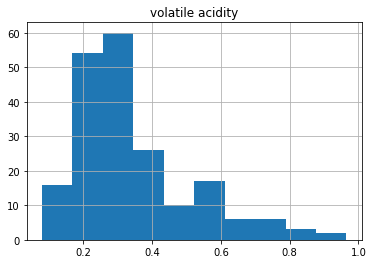

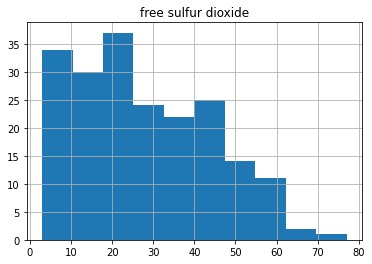

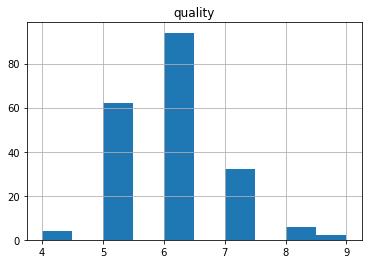

In [30]:
# volatile acids histogram
va_hist = samples.hist('volatile acidity')
ca_hist = samples.hist('free sulfur dioxide')
rs_hist = samples.hist('quality')

It seems like the 'volatile acidity' values in the sample data comes from an F-distribution, whereas the 'free sulfur dioxide' values look like a $\chi_3^2$ distribution and the 'quality' values look like a normal distribution.

In general, it is clear that the distribution of the data is not symmetric in any way.
Additionally, the tails of each variable are relatively consistent, therefore it is reasonable to assume that there are no missing values or significant outliers.

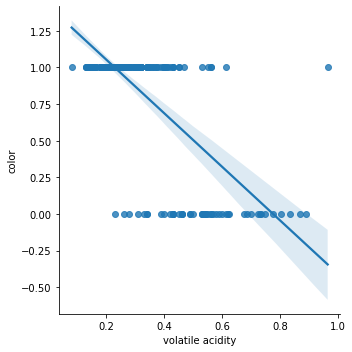

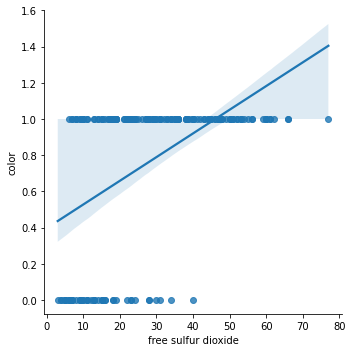

In [31]:
for col in ['volatile acidity', 'free sulfur dioxide']:
    sns.lmplot(x=col, y='color', data=samples, fit_reg=True, robust=True)

It seems as though 'volatile acidity' and 'free sulfur dioxide' have the most significant effect on wine color since the distribution of these variables are completely different for each wine color.  

<AxesSubplot:title={'center':'color'}, xlabel='quality'>

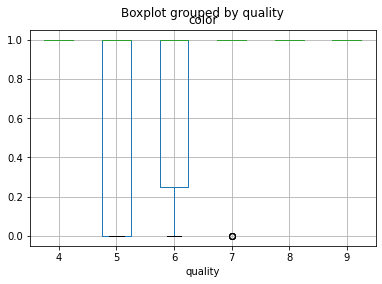

In [32]:
# Boxplot of 'quality' values for every rounded pH value
rounded_pH_df = samples
rounded_pH_df.boxplot(column='color', by='quality')

## Question 4: 

In [33]:
X_np = samples[['volatile acidity', 'quality', 'free sulfur dioxide']].to_numpy()
X = np.concatenate([np.ones((200, 1)), X_np], axis=1)
Y = samples['color'].to_numpy()
logistic = sm.Logit(Y, X).fit()
print(f"The coefficients are {logistic.params}")

Optimization terminated successfully.
         Current function value: 0.230111
         Iterations 8
The coefficients are [  2.10688222 -12.20401511   0.18420706   0.1312889 ]


In [34]:
cols = ['volatile acidity', 'quality', 'free sulfur dioxide']
for param, col in zip(logistic.params, cols):
    if param > 0:
        print(f"An increase of one unit in {col} causes an increase in the log of oddds ratio of {param}")
    else:
        print(f"An increase of one unit in {col} causes an decrease in the log of oddds ratio of {param}")

An increase of one unit in volatile acidity causes an increase in the log of oddds ratio of 2.1068822165225556
An increase of one unit in quality causes an decrease in the log of oddds ratio of -12.20401511129955
An increase of one unit in free sulfur dioxide causes an increase in the log of oddds ratio of 0.18420706343332627


## Question 5:

In [35]:
preds = logistic.predict(X)
diag = np.diag([p*(1-p) for p in preds])
C = np.linalg.inv(X.T @ diag @ X)
se = np.sqrt(np.diag(C))
ci_l, ci_u = np.zeros(len(logistic.params)), np.zeros(len(logistic.params))
for i, param in enumerate(logistic.params):
    ci_l[i] = param - 2 * se[i]
    ci_u[i] = param + 2 * se[i]
    print(f"The CI for beta {i} is [{ci_l[i]}, {ci_u[i]}]")

The CI for beta 0 is [-2.178772755794616, 6.392537188839727]
The CI for beta 1 is [-16.59539747025448, -7.812632752344619]
The CI for beta 2 is [-0.4487153380671314, 0.8171294649337839]
The CI for beta 3 is [0.06957984294340974, 0.19299796553455956]


In [36]:
X_np_all = total_edited[['volatile acidity', 'quality', 'free sulfur dioxide']].to_numpy()
X_all = np.concatenate([np.ones((total_edited.shape[0], 1)), X_np_all], axis=1)
Y_all = total_edited['color'].to_numpy()
logistic_total = sm.Logit(Y_all, X_all).fit()
print(f"Parameters based on the entire dataset: {logistic_total.params}")

Optimization terminated successfully.
         Current function value: 0.257486
         Iterations 8
Parameters based on the entire dataset: [  5.13645809 -11.93487351  -0.33163912   0.10213907]


In [37]:
# Check if total data estimators are in sample confidence interval
for i in range(len(logistic_total.params)):
    print(f"Total data estimator in sample CI: {(ci_l[i] < logistic_total.params[i] < ci_u[i])}")

Total data estimator in sample CI: True
Total data estimator in sample CI: True
Total data estimator in sample CI: True
Total data estimator in sample CI: True


## Question 6:

In [38]:
z12 = X_np[:,0] * X_np[:,1]
z23 = X_np[:,1] * X_np[:,2]
z13 = X_np[:,0] * X_np[:,2]
X_alt = np.concatenate([np.ones((200, 1)), X_np, z12.reshape(200,1), z23.reshape(200,1), z13.reshape(200,1)], axis=1)
Y = samples['color'].to_numpy()
logistic_alt = sm.Logit(Y, X_alt).fit()

Optimization terminated successfully.
         Current function value: 0.225178
         Iterations 9


As seen in the lecture, the likelihood ratio test tests the following hypothesis:
$$
 H_0: \beta_4 = \beta_5 = \beta_6 = 0
$$
$$
 H_1: \beta_j \ne 0 \text{ for at least one } j>3 
$$
$$
T.S. : \lambda = 2 \left(\ell_n (\hat\beta) - \ell_n(\hat\beta_{0,n}\right)
$$
$$
R.R. : \lambda > \chi_{k,\alpha}^2
$$

In [39]:
q, r = 4, 7

def sigmoid(x):
    return 1/(1+np.exp(-x))

    
def log_likelihood(data, labels, reg_model):
    """
    return the log likelihood of the logistic regression model
    """
    probs_for_pos = sigmoid(reg_model.params @ data.T)
    likelihood = labels * probs_for_pos + (1-labels) * (1-probs_for_pos)
    log_like = np.log(likelihood)
    return np.sum(log_like)

In [40]:
alt_log_likelihood = log_likelihood(X_alt, Y, logistic_alt)
null_log_likelihood = log_likelihood(X, Y, logistic)
lam = 2*(alt_log_likelihood - null_log_likelihood)
rej = (lam > chi2.ppf(0.95, 3))
if not rej:
    print("Interaction parameters are 0, hence null model is better")
else:
    print("At least one interaction parameter is nonzero, hence interactive model is better")

Interaction parameters are 0, hence null model is better


Next, we will consider the BIC (Bayesian Information Criterion):

In [41]:
def BIC(data, labels, reg_model):
    # log_like = log_likelihood(data, labels, reg_model)
    log_like = reg_model.llf
    n, s = data.shape
    return log_like - s/2 * np.log(n)

BIC_reg = BIC(X, Y, logistic)
BIC_alt = BIC(X_alt, Y, logistic_alt)

if BIC_reg > BIC_alt:
    print("The null model is better")
else:
    print("The interactive model is better")

The null model is better


Both the log-likelihood method and the Bayesian criterion method imply that the null model is better, therefore we accept the result.

## Question 7:

In [42]:
# Forward:
def create_cols():
    cols = list(samples.columns)
    cols = [col1 if col1==col2 else col1+'_'+col2 for col1 in cols for col2 in cols if col1<=col2]
    # cols = ['volatile acidity', 'quality', 'free sulfur dioxide', 'volatile acidity_quality', 'quality_free sulfur dioxide', 
    #     'volatile acidity_free sulfur dioxide']
    return cols

X_for = X[:,0].reshape(200,1) # start with ones
init_model = sm.Logit(Y, X_for).fit(disp=0, method='bfgs')
optimal_BIC = BIC(X_for, Y, init_model)
print(f"The BIC with just the intercept is {optimal_BIC}")

The BIC with just the intercept is -114.00418203650125


In [43]:
print(samples.columns)
col2idx = {}
for idx, col in enumerate(create_cols()):
    col2idx[col] = idx

Index(['fixed acidity', 'color', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


In [44]:
print(cols)

['volatile acidity', 'quality', 'free sulfur dioxide']


In [45]:
optimal = ['ones']
# cols = ['volatile acidity', 'quality', 'free sulfur dioxide', 'volatile acidity_quality', 'quality_free sulfur dioxide', 
#         'volatile acidity_free sulfur dioxide']
cols = create_cols()
max_iter = range(len(cols))
for i in max_iter:
    best_col = None
    for col in cols:
        X_col = X_for.copy()
        if '_' not in col:
            X_col = np.concatenate([X_col, samples[col].to_numpy().reshape(200, 1)], axis=1)
        else:
            col1, col2 = col.split('_')
            X_col = np.concatenate([X_col, (samples[col1] * samples[col2]).to_numpy().reshape(200, 1)], axis=1)
        with warnings.catch_warnings(): # silence warnings
            warnings.filterwarnings("ignore")
            col_reg = sm.Logit(Y, X_col).fit(disp=0, method='bfgs')
        BIC_col = BIC(X_col, Y, col_reg)
        if BIC_col> optimal_BIC:
            best_col = col
            best_BIC = BIC_col

    if best_col is None:
        break
    if '_' not in best_col:
        X_for = np.concatenate([X_for, samples[best_col].to_numpy().reshape(200, 1)], axis=1)
        cols.remove(best_col)
    else:
        col1, col2 = best_col.split('_')
        X_for = np.concatenate([X_for, (samples[col1] * samples[col2]).to_numpy().reshape(200, 1)], axis=1)
        cols.remove(best_col)
    optimal.append(best_col)
print(f"Using {list(optimal)}, acheive BIC of {best_BIC}")

Using ['ones', 'quality', 'quality_sulphates', 'quality_total sulfur dioxide', 'quality_residual sugar', 'quality_volatile acidity', 'alcohol_quality', 'alcohol', 'alcohol_sulphates', 'alcohol_pH', 'alcohol_density', 'alcohol_total sulfur dioxide', 'alcohol_free sulfur dioxide', 'alcohol_chlorides', 'alcohol_residual sugar', 'alcohol_citric acid', 'alcohol_volatile acidity', 'alcohol_color', 'alcohol_fixed acidity', 'sulphates', 'sulphates_total sulfur dioxide', 'sulphates_volatile acidity', 'pH_quality', 'pH_sulphates', 'pH', 'pH_total sulfur dioxide', 'pH_residual sugar', 'pH_volatile acidity', 'density_quality', 'density_sulphates', 'density_pH', 'density', 'density_total sulfur dioxide', 'density_free sulfur dioxide', 'density_residual sugar', 'density_volatile acidity', 'density_fixed acidity', 'total sulfur dioxide', 'total sulfur dioxide_volatile acidity', 'free sulfur dioxide_quality', 'free sulfur dioxide_sulphates', 'free sulfur dioxide_pH', 'free sulfur dioxide_total sulfur 

In [46]:
print(len(optimal))

43


In [47]:
# create array of first order interactions
X_inter = np.ones((200, 1))
cols = create_cols()
for col in cols:
    if '_' not in col:
        X_inter = np.concatenate([X_inter, samples[col].to_numpy().reshape(200, 1)], axis=1)
    else:
        col1, col2 = col.split('_')
        X_inter = np.concatenate([X_inter, (samples[col1] * samples[col2]).to_numpy().reshape(200, 1)], axis=1)

In [48]:
# Backward:
# cols = create_cols()
# cols = ['volatile acidity', 'quality', 'free sulfur dioxide', 'volatile acidity_quality', 'quality_free sulfur dioxide', 
#         'volatile acidity_free sulfur dioxide']
optimal = cols
max_iter = range(len(cols))
X_back = X_inter.copy()
for i in max_iter:
    best_col = None
    del_idx = None
    for idx, col in enumerate(cols):
        X_col = X_back.copy()
        X_col = np.delete(X_col, col2idx[col], axis=1)
        with warnings.catch_warnings(): # silence warnings
            warnings.filterwarnings("ignore")
            col_reg = sm.Logit(Y, X_col).fit(disp=0, method='bfgs')
        BIC_col = BIC(X_col, Y, col_reg)
        if BIC_col> optimal_BIC:
            best_col = col
            best_BIC = BIC_col
            del_idx = idx
    if best_col is None:
        break
    X_back = np.delete(X_back, col2idx[best_col], axis=1)
    cols.remove(best_col)
    optimal.remove(best_col)
    for idx, c in enumerate(cols):
        if idx >= del_idx:
            col2idx[c] -= 1
    
print(f"Using {list(optimal)}, acheive BIC of {best_BIC}")

Using ['fixed acidity', 'fixed acidity_volatile acidity', 'fixed acidity_residual sugar', 'fixed acidity_free sulfur dioxide', 'fixed acidity_total sulfur dioxide', 'fixed acidity_pH', 'fixed acidity_sulphates', 'fixed acidity_quality', 'color_fixed acidity', 'color', 'color_volatile acidity', 'color_residual sugar', 'color_free sulfur dioxide', 'color_total sulfur dioxide', 'color_density', 'color_pH', 'color_sulphates', 'color_quality', 'volatile acidity', 'citric acid_fixed acidity', 'citric acid_color', 'citric acid_volatile acidity', 'citric acid', 'citric acid_residual sugar', 'citric acid_free sulfur dioxide', 'citric acid_total sulfur dioxide', 'citric acid_density', 'citric acid_pH', 'citric acid_sulphates', 'citric acid_quality', 'residual sugar_volatile acidity', 'residual sugar', 'residual sugar_total sulfur dioxide', 'residual sugar_sulphates', 'chlorides_fixed acidity', 'chlorides_color', 'chlorides_volatile acidity', 'chlorides_citric acid', 'chlorides_residual sugar', '

As we can see, the results obtained in the forward and backward methods are very different.

## Question 8:

In [49]:
def AIC(data, labels, reg_model):
    # log_like = log_likelihood(data, labels, reg_model)
    log_like = reg_model.llf
    n, s = data.shape
    return log_like - s

In [50]:
X_for = X[:,0].reshape(200,1) # start with ones
init_model = sm.Logit(Y, X_for).fit(disp=0, method='bfgs')
optimal_AIC = AIC(X_for, Y, init_model)
print(f"The AIC with just the intercept is {optimal_AIC}")

The AIC with just the intercept is -112.35502335322722


In [51]:
optimal = ['ones']
# cols = ['volatile acidity', 'quality', 'free sulfur dioxide', 'volatile acidity_quality', 'quality_free sulfur dioxide', 
#         'volatile acidity_free sulfur dioxide']
cols = create_cols()
max_iter = range(len(cols))
for i in max_iter:
    best_col = None
    for col in cols:
        X_col = X_for.copy()
        if '_' not in col:
            X_col = np.concatenate([X_col, samples[col].to_numpy().reshape(200, 1)], axis=1)
        else:
            col1, col2 = col.split('_')
            X_col = np.concatenate([X_col, (samples[col1] * samples[col2]).to_numpy().reshape(200, 1)], axis=1)
        with warnings.catch_warnings(): # silence warnings
            warnings.filterwarnings("ignore")
            col_reg = sm.Logit(Y, X_col).fit(disp=0, method='bfgs')
        AIC_col = AIC(X_col, Y, col_reg)
        if AIC_col> optimal_AIC:
            best_col = col
            best_AIC = AIC_col

    if best_col is None:
        break
    if '_' not in best_col:
        X_for = np.concatenate([X_for, samples[best_col].to_numpy().reshape(200, 1)], axis=1)
        cols.remove(best_col)
    else:
        col1, col2 = best_col.split('_')
        X_for = np.concatenate([X_for, (samples[col1] * samples[col2]).to_numpy().reshape(200, 1)], axis=1)
        cols.remove(best_col)
    optimal.append(best_col)
print(f"Using {list(optimal)}, acheive AIC of {best_AIC}")

Using ['ones', 'quality', 'quality_sulphates', 'quality_total sulfur dioxide', 'quality_residual sugar', 'quality_volatile acidity', 'alcohol_quality', 'alcohol', 'alcohol_sulphates', 'alcohol_pH', 'alcohol_density', 'alcohol_total sulfur dioxide', 'alcohol_free sulfur dioxide', 'alcohol_chlorides', 'alcohol_residual sugar', 'alcohol_citric acid', 'alcohol_volatile acidity', 'alcohol_color', 'alcohol_fixed acidity', 'sulphates', 'sulphates_total sulfur dioxide', 'sulphates_volatile acidity', 'pH_quality', 'pH_sulphates', 'pH', 'pH_total sulfur dioxide', 'pH_residual sugar', 'pH_volatile acidity', 'density_quality', 'density_sulphates', 'density_pH', 'density', 'density_total sulfur dioxide', 'density_free sulfur dioxide', 'density_residual sugar', 'density_volatile acidity', 'density_fixed acidity', 'total sulfur dioxide', 'total sulfur dioxide_volatile acidity', 'free sulfur dioxide_quality', 'free sulfur dioxide_sulphates', 'free sulfur dioxide_pH', 'free sulfur dioxide_total sulfur 

In [52]:
print(len(optimal))

92


In [53]:
# create array of first order interactions
X_inter = np.ones((200, 1))
cols = create_cols()
for col in cols:
    if '_' not in col:
        X_inter = np.concatenate([X_inter, samples[col].to_numpy().reshape(200, 1)], axis=1)
    else:
        col1, col2 = col.split('_')
        X_inter = np.concatenate([X_inter, (samples[col1] * samples[col2]).to_numpy().reshape(200, 1)], axis=1)

for idx, col in enumerate(create_cols()):
    col2idx[col] = idx

In [54]:
# Backward:
optimal_AIC = best_AIC
cols = create_cols()
# cols = ['volatile acidity', 'quality', 'free sulfur dioxide', 'volatile acidity_quality', 'quality_free sulfur dioxide', 
#         'volatile acidity_free sulfur dioxide']
optimal = cols.copy()
max_iter = range(len(cols))
X_back = X_inter.copy()
for i in max_iter:
    best_col = None
    del_idx = None
    for idx, col in enumerate(cols):
        X_col = X_back.copy()
        X_col = np.delete(X_col, col2idx[col], axis=1)
        with warnings.catch_warnings(): # silence warnings
            warnings.filterwarnings("ignore")
            col_reg = sm.Logit(Y, X_col).fit(disp=0, method='bfgs')
        AIC_col = AIC(X_col, Y, col_reg)
        if AIC_col > optimal_AIC:
            best_col = col
            best_AIC = AIC_col
            del_idx = idx
    if best_col is None:
        break
    X_back = np.delete(X_back, col2idx[best_col], axis=1)
    cols.remove(best_col)
    optimal.remove(best_col)
    for idx, c in enumerate(cols):
        if idx >= del_idx:
            col2idx[c] -= 1
optimal.append('ones')
    
print(f"Using {list(optimal)}, acheive AIC of {best_AIC}")

Using ['fixed acidity_volatile acidity', 'ones'], acheive AIC of -86.6721809789492


As we can see, the results are different for each method and each criterion. The reason for this is that both methods are not optimal and the criteria are different.